<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%B0%D0%B2%D1%82%D0%BE%D1%80%D1%81%D1%82%D0%B2%D0%B0%20%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе 
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым 

Ссылка на архив: https://storage.googleapis.com/datasets_ai/Data/writers25.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

In [ ]:
# ваше решение
# импорт библиотек
import numpy as np
import gdown
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import RMSprop
from itertools import chain

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Data/writers25.zip', None, quiet=True)

'writers25.zip'

In [ ]:
# Распаковка архива в папку writers
!unzip -qo writers25.zip -d writers/

# Просмотр содержимого папки
!ls writers

rec_1d


In [ ]:
# Объявляем функции для чтения файла. На вход отправляем путь к файлу
def read_text(file_name):

  # Задаем открытие нужного файла в режиме чтения              
  read_file = open(file_name, 'r', encoding="cp1251")

  # Читаем текст     
  text = read_file.read()

  # Переносы строки переводим в пробелы              
  text = text.replace("\n", " ")

  # Возвращаем текст файла       
  return text 

# Объявляем интересующие нас классы
class_names = ["Беляев", "Булгаков", "Васильев", "Гоголь", "Гончаров", "Горький", "Грибоедов",
               "Достоевский", "Каверин", "Катаев", "Куприн", "Лермонтов", "Лесков", "Носов", 
               "Пастернак", "Пушкин", "Толстой", "Тургенев", "Чехов", "Шолохов"]
               
# Считаем количество классов 
num_classes = len(class_names)

In [ ]:
# Создаём список под тексты для обучающей выборки
texts_list = []

# Циклом проводим итерацию по текстовым файлам в папке отзывов
for j in os.listdir('/content/writers/rec_1d/writters/'):

  # Добавляем каждый файл в общий список для выборки
        texts_list.append(read_text('/content/writers/rec_1d/writters/' + j))
        
        # Выводим на экран сообщение о добавлении файла
        print(j, 'добавлен в обучающую выборку')

Гоголь.txt добавлен в обучающую выборку
Гончаров.txt добавлен в обучающую выборку
Пушкин.txt добавлен в обучающую выборку
Носов.txt добавлен в обучающую выборку
Горький.txt добавлен в обучающую выборку
Лесков.txt добавлен в обучающую выборку
Грибоедов.txt добавлен в обучающую выборку
Чехов.txt добавлен в обучающую выборку
Достоевский.txt добавлен в обучающую выборку
Каверин.txt добавлен в обучающую выборку
Пастернак.txt добавлен в обучающую выборку
Катаев.txt добавлен в обучающую выборку
Тургенев.txt добавлен в обучающую выборку
Лермонтов.txt добавлен в обучающую выборку
Куприн.txt добавлен в обучающую выборку
Шолохов.txt добавлен в обучающую выборку
Толстой.txt добавлен в обучающую выборку
Васильев.txt добавлен в обучающую выборку
Булгаков.txt добавлен в обучающую выборку
Беляев.txt добавлен в обучающую выборку


In [ ]:
# Узнаем объём каждого текста в словах и символах
texts_len = [len(text) for text in texts_list]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Выводим на экран  информационное сообщение
print(f'Размеры текстов по порядку (в токенах):')

# Циклом проводим итерацию по списку с объёмами текстов
for text_len in texts_len:

  # Запускаем "счётчик" номера текста
  t_num += 1
  
  # Выводим на экран сообщение о номере и объёме текста
  print(f'Текст №{t_num}: {text_len}')

Размеры текстов по порядку (в токенах):
Текст №1: 1965118
Текст №2: 3104711
Текст №3: 3408338
Текст №4: 2399412
Текст №5: 2523379
Текст №6: 2152212
Текст №7: 969108
Текст №8: 6611626
Текст №9: 5178949
Текст №10: 1992829
Текст №11: 3089425
Текст №12: 2579245
Текст №13: 1980205
Текст №14: 1972540
Текст №15: 2328899
Текст №16: 3386267
Текст №17: 3357060
Текст №18: 2952791
Текст №19: 2001063
Текст №20: 2255253


In [ ]:
# Создадим пустые списки для обучающей и проверочной выборок
train_data = []
test_data = []

# Циклом пройдёмся по 20 текстам 
for i in range(len(texts_list)):

  # Выделим 80% каждого текста на обучающую и 20% на проверочную
  train_len = int(len(texts_list[i])*0.8)
  
  # Добавим тексты в выборки функцией chain()
  train_data = list(chain(train_data, ([texts_list[i][:train_len]])))
  test_data = list(chain(test_data, ([texts_list[i][train_len:]])))

In [ ]:
# Задание параметров преобразования
# Объем словаря для токенизатора
VOCAB_SIZE = 20000
# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000
# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

In [ ]:
# Используется токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      oov_token='неизвестное_слово',)
# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(train_data)
    
# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items)) 

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('с', 7), ('я', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('у', 19), ('она', 20), ('все', 21), ('из', 22), ('так', 23), ('же', 24), ('от', 25), ('ты', 26), ('было', 27), ('вы', 28), ('да', 29), ('мне', 30), ('о', 31), ('меня', 32), ('ее', 33), ('бы', 34), ('только', 35), ('был', 36), ('ему', 37), ('еще', 38), ('когда', 39), ('вот', 40), ('сказал', 41), ('мы', 42), ('они', 43), ('ни', 44), ('до', 45), ('уже', 46), ('их', 47), ('нет', 48), ('ну', 49), ('для', 50), ('него', 51), ('или', 52), ('если', 53), ('ли', 54), ('теперь', 55), ('под', 56), ('быть', 57), ('вас', 58), ('себя', 59), ('где', 60), ('была', 61), ('очень', 62), ('во', 63), ('даже', 64), ('есть', 65), ('вам', 66), ('ничего', 67), ('со', 68), ('чем', 69), ('были', 70), ('может', 71), ('тут', 72), ('кто', 73), ('чтобы', 74), ('себе', 75), ('потом', 76), ('всё', 77),

In [ ]:
# Преобразование обучающих и проверочных текстов текст в последовательности индексов согласно частотному словарю
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", train_data[1][:101])
print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               Обломов ЧАСТЬ ПЕРВАЯ I В Гороховой улице, в одном из больших домов, народонаселения которого стало бы
Он же в виде последовательности индексов:  [669, 718, 1219, 1599, 3, 1, 587, 3, 561, 22, 1841, 1986, 1, 253, 212, 34, 5, 724, 11772, 393]


In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP) 
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(69083, 1000) (69083, 20)
(17225, 1000) (17225, 20)


Epoch 1/10
540/540 [==============================] - 12s 22ms/step - loss: 2.3023 - accuracy: 0.7760 - val_loss: 1.1751 - val_accuracy: 0.6491
Epoch 2/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 1.2666 - val_accuracy: 0.8269
Epoch 3/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 1.6261 - val_accuracy: 0.8231
Epoch 4/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 1.6121 - val_accuracy: 0.8402
Epoch 5/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 1.5495 - val_accuracy: 0.8416
Epoch 6/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 1.3879 - val_accuracy: 0.8590
Epoch 7/10
540/540 [==============================] - 11s 21ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 1.5091 - val_accuracy:

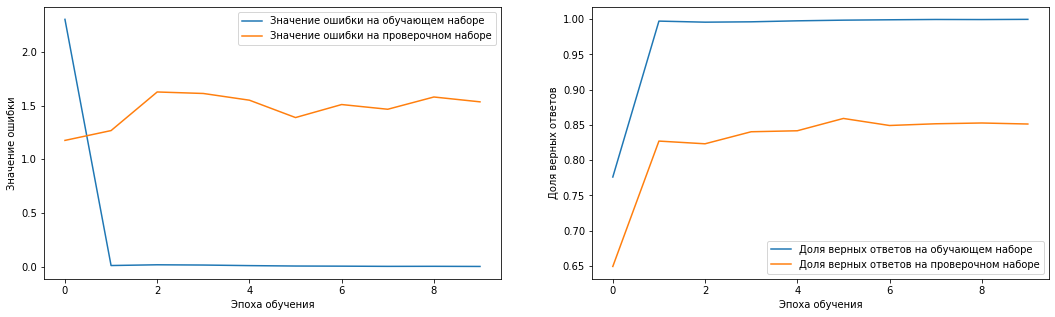

In [ ]:
#создаем последовательную модель
model = Sequential()
#добавляем слой Embedding
model.add(Embedding(VOCAB_SIZE, 100, input_length=WIN_SIZE))
#слой регуляризации
model.add(SpatialDropout1D(0.1))
#слой нормализации
model.add(BatchNormalization())
#сверточный слой
model.add(Conv1D(128, 3, activation='relu', padding='same'))
#слой MaxPooling
model.add(MaxPooling1D(3))
#слой преобразования
model.add(Flatten())
#выходной полносвязный слой
model.add(Dense(20, activation='softmax'))

#компиляция модели
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                metrics=['accuracy'])

#обучаем сеть
history = model.fit(x_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(x_test, y_test))

# выведем графики обучения
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss'
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy'
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

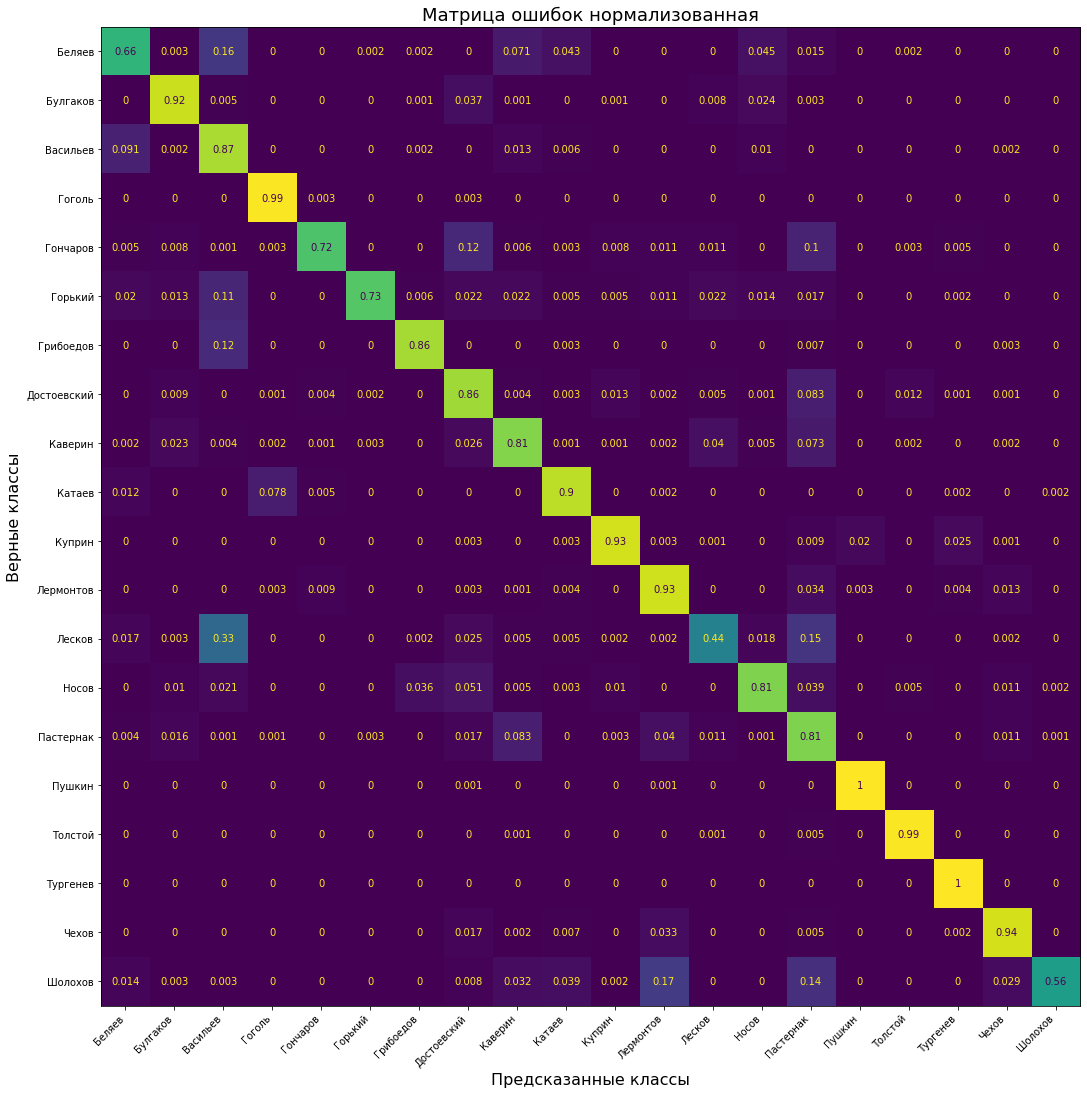

Класс: Беляев        66% сеть отнесла к классу Беляев       - ВЕРНО :-)
Класс: Булгаков      92% сеть отнесла к классу Булгаков     - ВЕРНО :-)
Класс: Васильев      87% сеть отнесла к классу Васильев     - ВЕРНО :-)
Класс: Гоголь       100% сеть отнесла к классу Гоголь       - ВЕРНО :-)
Класс: Гончаров      72% сеть отнесла к классу Гончаров     - ВЕРНО :-)
Класс: Горький       74% сеть отнесла к классу Горький      - ВЕРНО :-)
Класс: Грибоедов     86% сеть отнесла к классу Грибоедов    - ВЕРНО :-)
Класс: Достоевский   86% сеть отнесла к классу Достоевский  - ВЕРНО :-)
Класс: Каверин       81% сеть отнесла к классу Каверин      - ВЕРНО :-)
Класс: Катаев        90% сеть отнесла к классу Катаев       - ВЕРНО :-)
Класс: Куприн        93% сеть отнесла к классу Куприн       - ВЕРНО :-)
Класс: Лермонтов     93% сеть отнесла к классу Лермонтов    - ВЕРНО :-)
Класс: Лесков        44% сеть отнесла к классу Лесков       - ВЕРНО :-)
Класс: Носов         81% сеть отнесла к классу Носов        - ВЕ

In [ ]:
# Вычисление предсказания сети
y_pred = model.predict(x_test)
# Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true')
# Округление значений матрицы ошибок
cm = np.around(cm, 3)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title('Матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax)
# Стирание ненужной цветовой шкалы
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()

# Для каждого класса:
for cls in range(num_classes):
    # Определяется индекс класса с максимальным значением предсказания (уверенности)
    cls_pred = np.argmax(cm[cls])
    # Формируется сообщение о верности или неверности предсказания
    msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
    # Выводится текстовая информация о предсказанном классе и значении уверенности
    print('Класс: {:<12} {:3.0f}% сеть отнесла к классу {:<12} - {}'.format(class_names[cls], 100. * cm[cls, cls_pred], class_names[cls_pred], msg))

print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# загрузим проверочный текст
# Создаём список
text = []
# Добавляем файл в список для выборки
text.append(read_text('/content/ДД.txt'))
# преобразуем в последовательность индексов
test = tokenizer.texts_to_sequences(text)
# сформируем данные
# Разбиение на отрезки
x = [test[0][i:i + WIN_SIZE] for i in range(0, len(test[0]) - WIN_SIZE + 1, WIN_HOP)]
# преобразование в numpy-массив
x = np.array(x)
x.shape

(19, 1000)

In [ ]:
# Вычисление предсказания сети
y_pred = model.predict(x)
y = np.argmax(y_pred, axis=1)
unique, counts = np.unique(y, return_counts=True)
pp = dict(zip(unique, counts))
print('Распознано:')
for i, name in enumerate(class_names):
    if i in pp:
        print(round(pp[i]/len(y)*100, 2), '% - ', name, sep='')

Распознано:
10.53% - Каверин
31.58% - Катаев
10.53% - Куприн
5.26% - Пастернак
31.58% - Тургенев
10.53% - Чехов


Вот так опознала текст "Дневной дозор" Лукьяненко наша нейронка.